In [36]:
import shlex, subprocess
import os
import gzip
import re
import scipy as sp
import numpy.random as rd
import matplotlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
from operator import itemgetter
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

# Vowpal wabbit commands and Brief Description of data

###It generates uncertainty scores for ftrl regression model with --ftrl_confidence argument in command args.
###The outputs look like below: 

    prediction uncertainty score
    -0.917181 1.581583
    -1.040545 1.582132
    -1.098954 1.591752
    -1.280777 1.592833
    -1.290698 1.625208
    -1.404583 1.701759
    -1.545548 1.482271
    ...       ....


### The score is calculated based on the following research paper, section (6): https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf

###vw command: vw -d data.gz --loss_function logistic --ftrl --ftrl_alpha 0.073 --ftrl_beta 0.1 --ignore v -q du --lrq ap10 -p pred_with_ce_original.out --ftrl_confidence
### Data of over 3 million samples from Nativo's online ad-serving events

# converting probability to logodds

In [3]:
def prob_to_logodds(myprob):
    return sp.log(myprob/(1-myprob))

#parsing data in the format of prediction and uncertain scores

In [5]:
def parsing(inp):    
    DATAFILE_PATTERN = '^(.+) (.+)'
    match = re.search(DATAFILE_PATTERN, inp)
    return (float(match.group(1)), float(match.group(2)))

In [6]:
#predictions and uncertainty scores from the ftrl model and --ftrl_confidence option
pred_with_ce = []
with open("pred_with_ce_original.out", "r") as f:
      for line in f:
        pred_with_ce.append(parsing(line))

#predictions from the "ground truth" model

In [4]:
pred1 = []
with open("pred_original.out", "r") as f:
      for line in f:
        pred1.append(prob_to_logodds(float(line)))

# Distribute uncertainty scores uniformly in the interval of zero to one (for display purposes below).

In [14]:
np_errors = np.array(errors)
ce = map(lambda x: x[1][1]  ,zip(pred1, pred_with_ce))
np_ce = np.array(ce)
from scipy.stats import rankdata
np_ce = rankdata(np_ce) / len(np_ce)

In [15]:
errors = map(lambda x: sp.absolute(x[1][0]-x[0]),zip(pred1, pred_with_ce))

# Calculate 25, 50, and 75 Percentiles 

In [50]:
errors_ce = sorted(zip(np_errors, np_ce), key=itemgetter(1))
errors_ce_errors= map(lambda x: x[0], errors_ce)
cuts = 1000
myrange = np.array(range(0,cuts + 1))/float(cuts)*len(errors_ce_errors)
#calculate 25, 50, and 75 percentiles
q25 = []
q50= []
q75= []
q90=[]
q95=[]
q99=[]
for i in range(0,cuts):
    filt_dat = errors_ce_errors[int(myrange[i]):int(myrange[i+1])]
    q25.append(np.percentile(filt_dat, 25))
    q50.append(np.percentile(filt_dat, 50))
    q75.append(np.percentile(filt_dat, 75))
    q90.append(np.percentile(filt_dat, 90))
    q95.append(np.percentile(filt_dat, 95))
    q99.append(np.percentile(filt_dat, 99))

In [29]:
myxrange = np.array(range(0,cuts))/float(cuts)

# The figure below shows the plot of log-odds error quartiles. The y-axis shows the log-odds error, the x-axis shows the uniformly distributed uncertainty score quantiles (x-axis, normalized to 0-1 range). It shows the correlation between uncertainties and prediction errors. 

## For comparison, see Figure 3. in the paper located at https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf

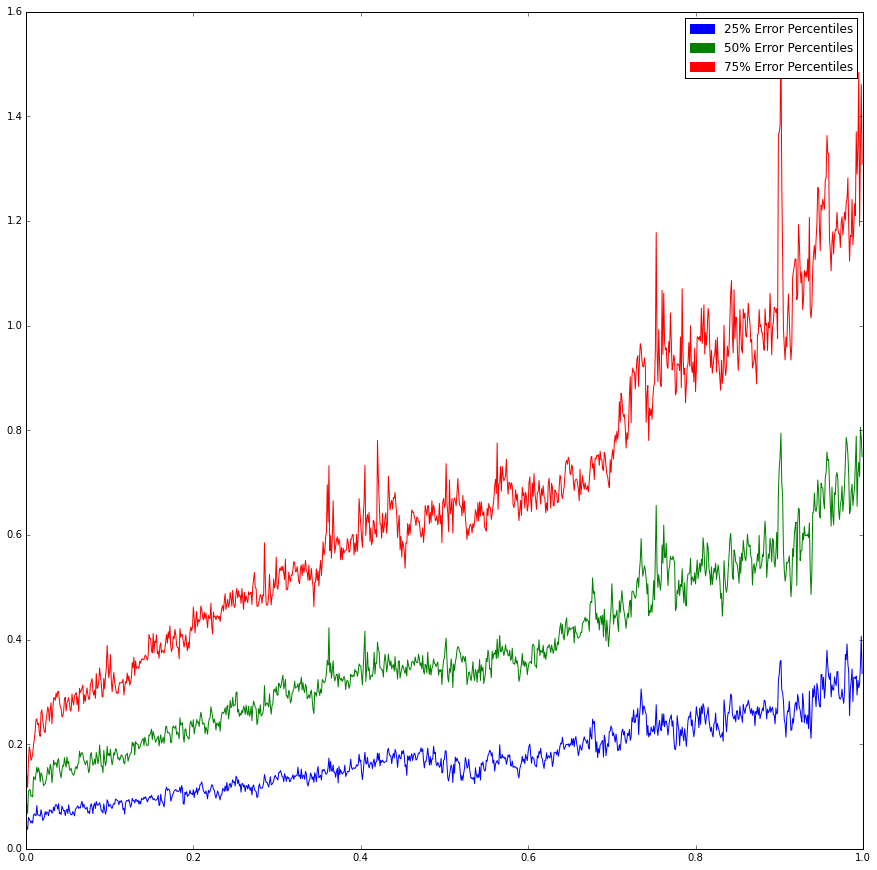

In [44]:
myxrange = np.array(range(0,cuts))/float(cuts)
red_patch = mpatches.Patch(color='red', label='75% Error Percentiles')
blue_patch = mpatches.Patch(color='blue', label='25% Error Percentiles')
green_patch = mpatches.Patch(color='green', label='50% Error Percentiles')

plt.figure(figsize=(15,15))
plt.plot(myxrange, q25)
plt.plot(myxrange, np.array(q50))
plt.plot(myxrange, np.array(q75))
plt.legend(handles=[blue_patch, green_patch, red_patch])
plt.show()

# Below is the same plot as above plus density plot of errors by uncertainty scores.
## The 90th, 95th, and 99th percentile curves are also shown (black lines).

<matplotlib.colorbar.Colorbar instance at 0x7f9478df9f38>

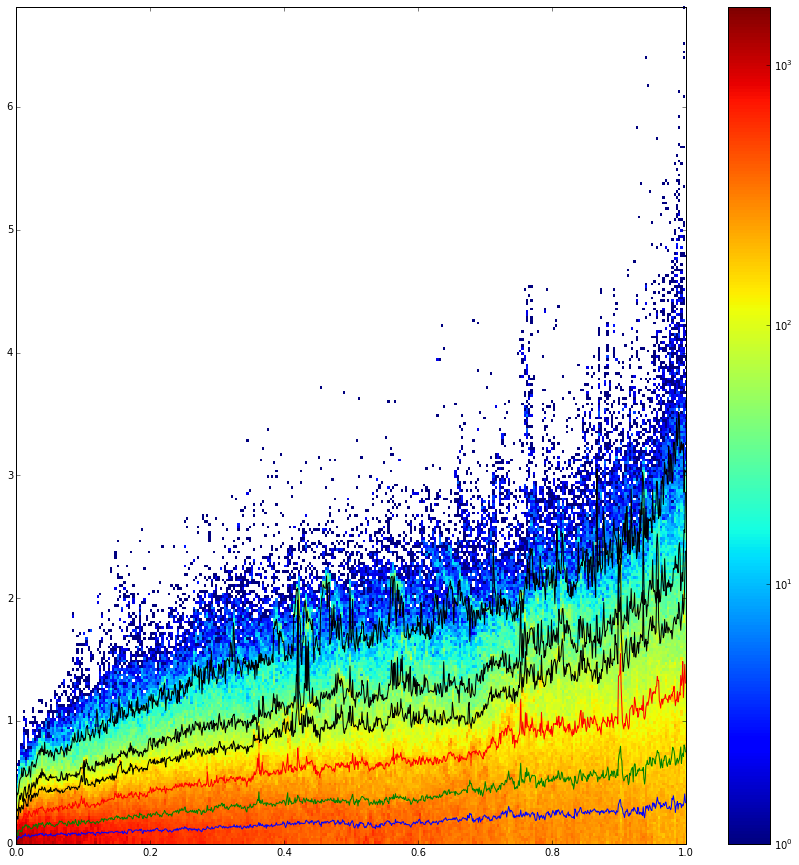

In [51]:
%matplotlib inline 
plt.figure(figsize=(15,15))
plt.hist2d( np_ce,  np_errors, bins=300, norm=LogNorm())
plt.plot(myxrange, q25, 'blue')
plt.plot(myxrange, q50, 'green')
plt.plot(myxrange, q75, 'red')
plt.plot(myxrange, q90, 'black')
plt.plot(myxrange, q95, 'black')
plt.plot(myxrange, q99, 'black')
plt.colorbar()